<a href="https://colab.research.google.com/github/Emna-chebbi/Machine-Learning-Project/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the relevant libraries

In [1]:
import pandas as pd

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

# Data Preprocessing

### Importing the Database

In [2]:
raw_data = pd.read_csv('ml_datasource.csv')
raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [3]:
data = raw_data.copy()

### Removing Outliers

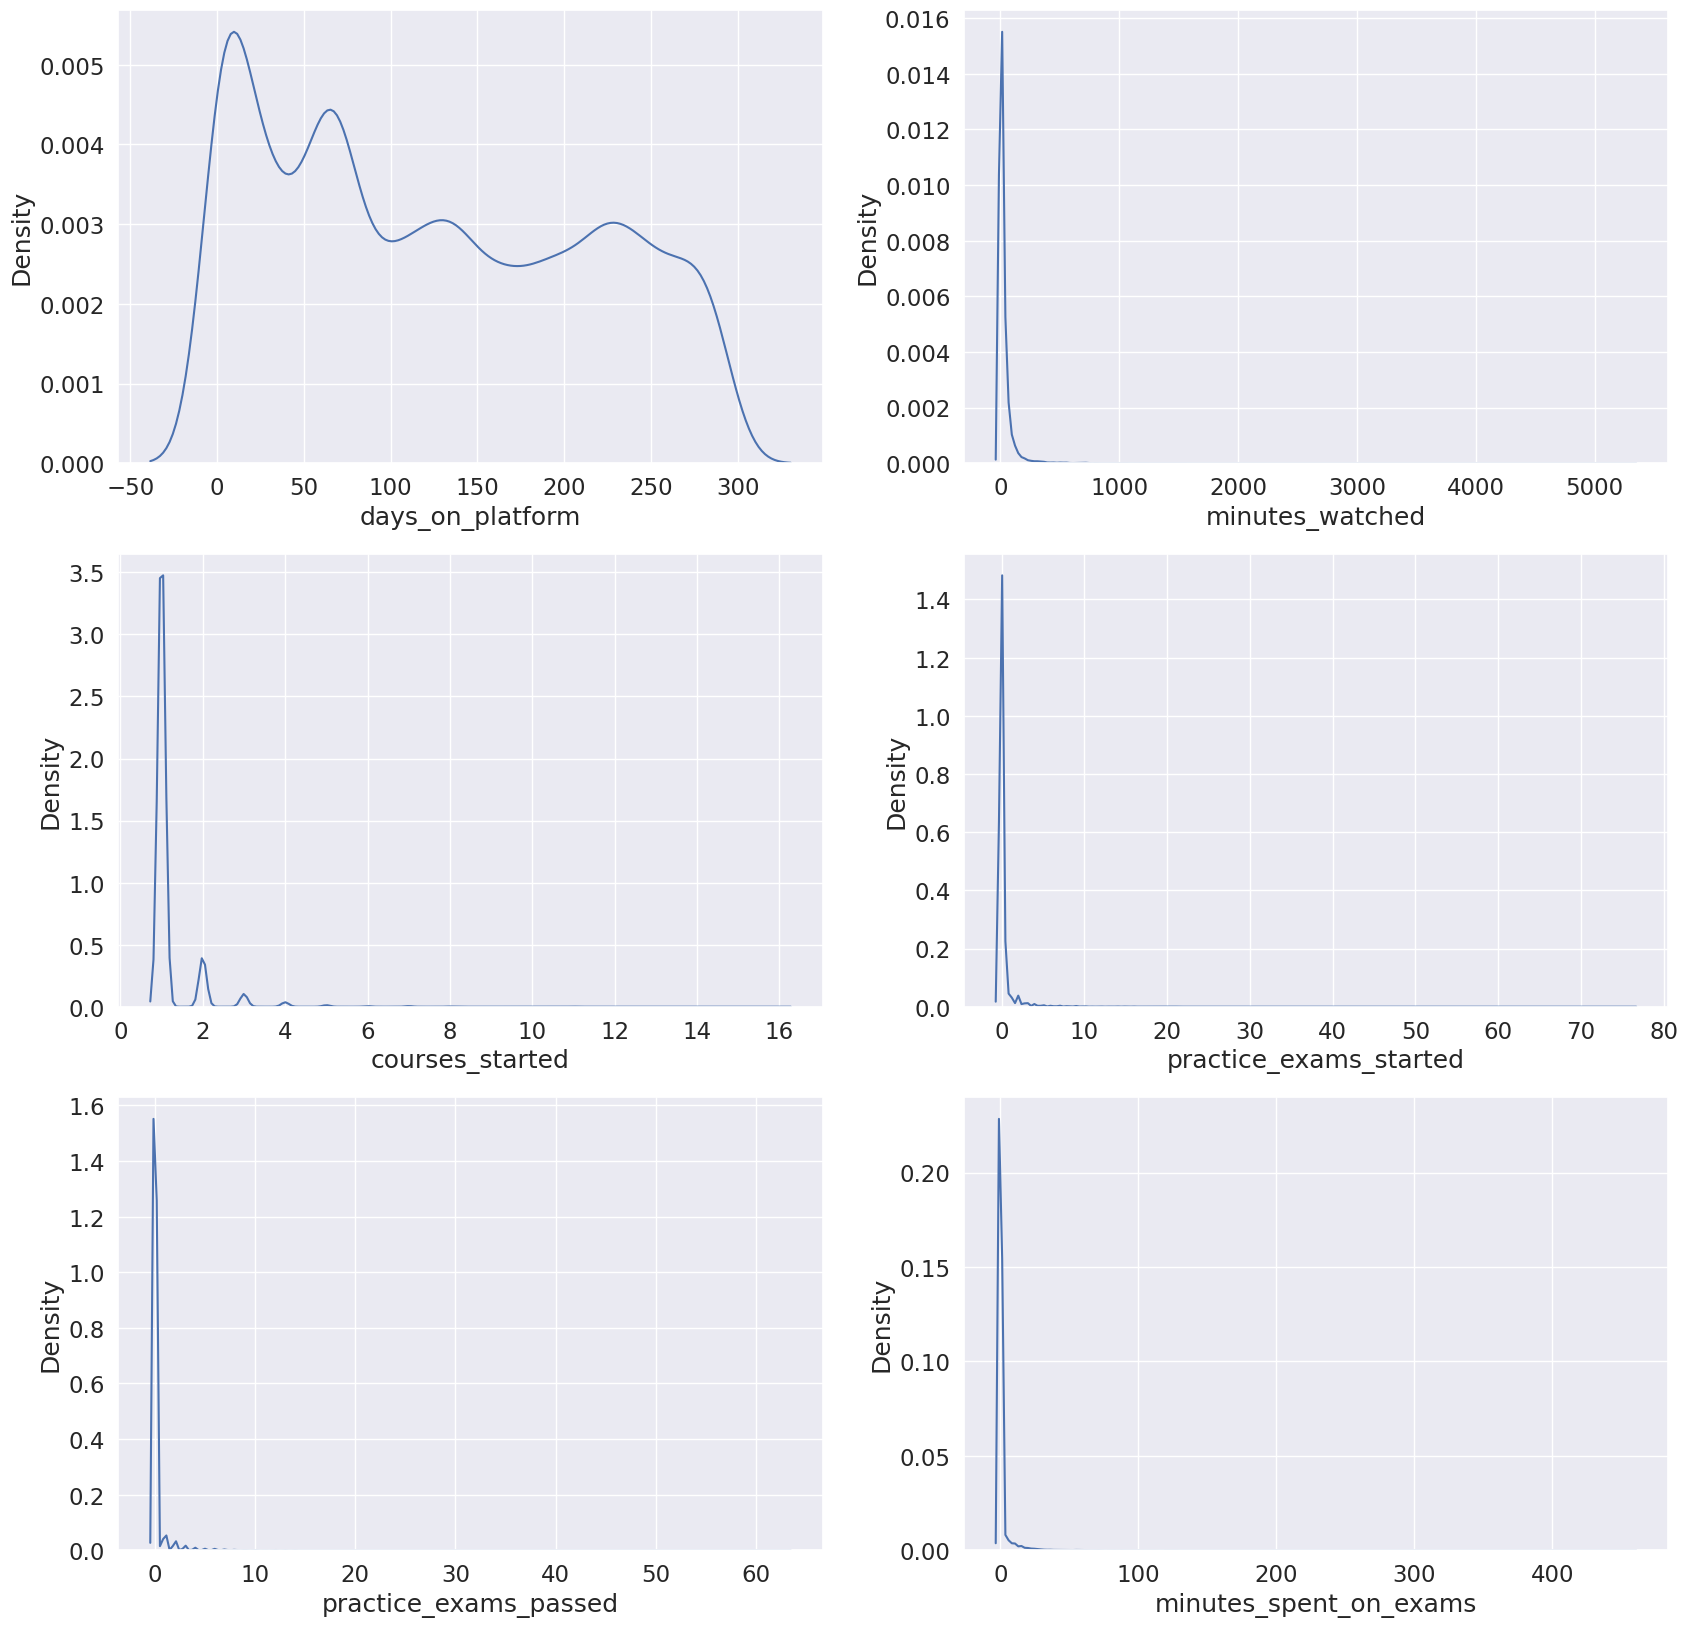

In [4]:
sns.reset_orig()
sns.set(font_scale=1.5)
fig, axes = plt.subplots(3, 2, figsize=(20,20))

sns.kdeplot(data=data['days_on_platform'], ax=axes[0,0])
sns.kdeplot(data=data['minutes_watched'], ax=axes[0,1])
sns.kdeplot(data=data['courses_started'], ax=axes[1,0])
sns.kdeplot(data=data['practice_exams_started'], ax=axes[1,1])
sns.kdeplot(data=data['practice_exams_passed'], ax=axes[2,0])
sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[2,1]);

plt.show()

In [5]:
data_no_outliers = data[(data['minutes_watched'] <= 1000)
                            & (data['courses_started']<=10)
                            & (data['practice_exams_started']<=10)
                            & (data['minutes_spent_on_exams']<=40)]

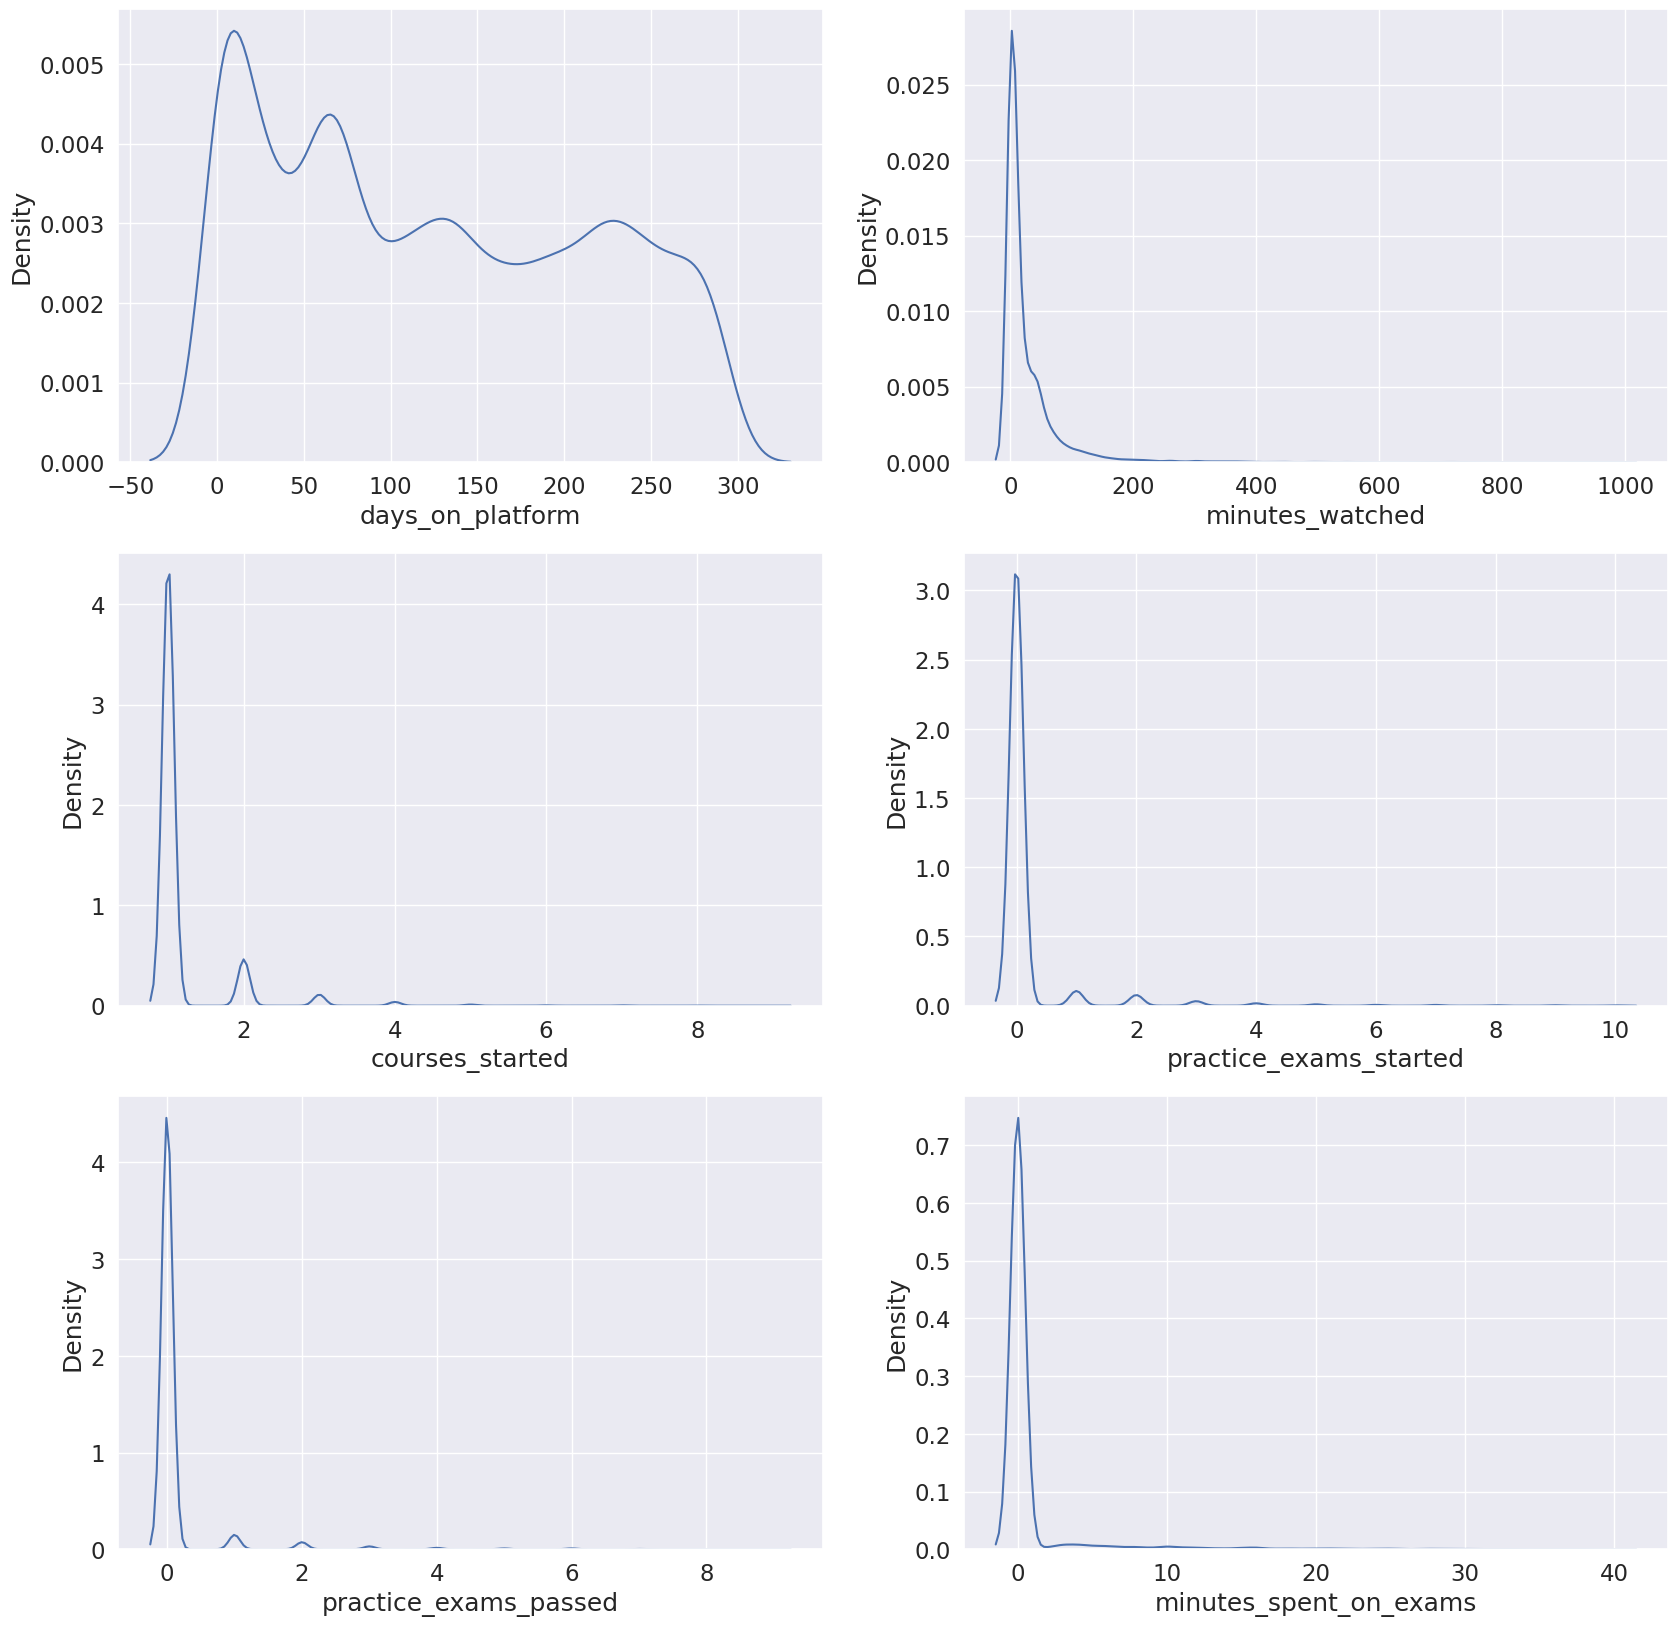

In [6]:
sns.reset_orig()
sns.set(font_scale=1.5)

fig, axes = plt.subplots(3, 2, figsize=(20,20))

sns.kdeplot(data=data_no_outliers['days_on_platform'], ax=axes[0,0])
sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0,1])
sns.kdeplot(data=data_no_outliers['courses_started'], ax=axes[1,0])
sns.kdeplot(data=data_no_outliers['practice_exams_started'], ax=axes[1,1])
sns.kdeplot(data=data_no_outliers['practice_exams_passed'], ax=axes[2,0])
sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[2,1]);

plt.show()

### Checking for Multicollinearity

In [7]:
data_no_outliers.columns.to_numpy()

array(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started',
       'practice_exams_passed', 'minutes_spent_on_exams', 'purchased'],
      dtype=object)

In [8]:
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started',
                              'practice_exams_started',
                              'practice_exams_passed',
                              'minutes_spent_on_exams']]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif

,VIF,features
0,2.301237,days_on_platform
1,1.788777,minutes_watched
2,3.178713,courses_started
3,10.201823,practice_exams_started
4,7.812546,practice_exams_passed
5,3.345478,minutes_spent_on_exams


In [9]:
# Dropping 'practice_exams' to prevent multicollinearity
data_no_mult = data_no_outliers.drop('practice_exams_started', axis = 1)
data_no_mult.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [10]:
# Selecting specific columns for new Variance Inflation Factor calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started',
                              'practice_exams_passed',
                              'minutes_spent_on_exams']]

# Computing the new VIF values for each selected feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,2.299940,days_on_platform
1,1.788276,minutes_watched
2,3.174319,courses_started
3,2.562412,practice_exams_passed
4,2.602966,minutes_spent_on_exams


### Dealing with NaN Values

In [11]:
data_no_mult.isnull().sum()

,0
student_country,8
days_on_platform,0
minutes_watched,0
courses_started,0
practice_exams_passed,0
minutes_spent_on_exams,0
purchased,0


In [12]:
data_no_mult.loc[ data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [13]:
data_no_nulls = data_no_mult.fillna('NAM', axis = 1)

In [14]:
data_no_nulls.loc[ data_no_nulls['student_country'] == 'NAM', 'student_country']

,student_country
311,NAM
337,NAM
556,NAM
806,NAM
1097,NAM
12363,NAM
12633,NAM
16946,NAM


In [15]:
data_no_nulls.isnull().sum()

,0
student_country,0
days_on_platform,0
minutes_watched,0
courses_started,0
practice_exams_passed,0
minutes_spent_on_exams,0
purchased,0


### Splitting the Data

In [16]:
inputs = data_no_nulls.drop(['purchased'],axis=1)
target = data_no_nulls['purchased']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(inputs,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=365,
                                                    stratify = target)

In [18]:
x_train.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams
5718,IN,218,1.6,2,0,0.0
3119,IN,263,75.5,1,0,0.0
5440,LK,222,44.4,1,0,0.0
11828,TR,97,2.6,1,0,0.0
8454,KR,162,1.0,1,0,0.0


### Encoding the Data

In [19]:
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',
                     unknown_value = 170);

In [20]:
x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1, 1));
x_test['student_country_enc'] = enc.transform(x_test['student_country'].to_numpy().reshape(-1, 1));

x_train = x_train.drop('student_country', axis = 1)
x_test = x_test.drop('student_country', axis = 1)
x_train.head()

,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
5718,218,1.6,2,0,0.0,69.0
3119,263,75.5,1,0,0.0,69.0
5440,222,44.4,1,0,0.0,84.0
11828,97,2.6,1,0,0.0,148.0
8454,162,1.0,1,0,0.0,80.0


In [21]:
x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')

x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

# Creating a Logistic Regression Model

In [22]:
log_reg = sm.Logit(y_train_array, x_train_array)
log_reg_results = log_reg.fit()
log_reg_results.summary()

Optimization terminated successfully.
         Current function value: 0.153146
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14094
Method:                           MLE   Df Model:                            5
Date:                Tue, 24 Dec 2024   Pseudo R-squ.:                  0.5019
Time:                        22:33:46   Log-Likelihood:                -2159.4
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0691      0.002    -31.914      0.000      -0.073      -0.065
x2             0.0144      0.001     19.992      0.000       0.013       0.016
x3            -0.2885      0.060     -4.784      0.000      -0.407      -0.170
x4             0.0840      0.076      1.102      0.270      -0.065       0.233
x5            -0.0670      0.015     -4.332      0.000      -0.097      -0.037
x6             0.0026      0.001      3.983      0.000       0.001       0.004
==============================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [23]:
y_test_pred_log_reg = [round(log_reg_results.predict(x_test_array)[i], 0)
                       for i in range(len(y_test_array))]

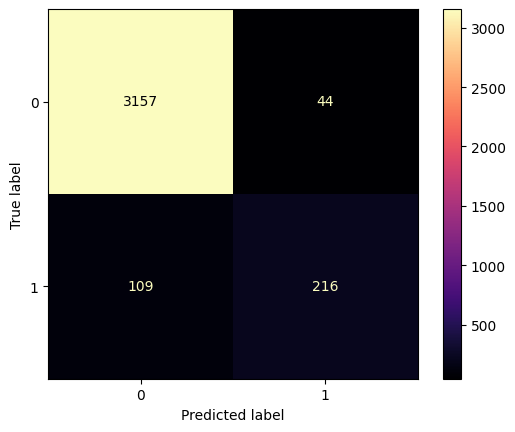

In [24]:
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_log_reg,
    cmap = 'magma'
);

plt.show()

# Creating a K-Nearest Neighbors Model

In [25]:
parameters_knn = {'n_neighbors':range(1, 51),
                  'weights':['uniform', 'distance']}

In [26]:
grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(),
                               param_grid = parameters_knn,
                               scoring = 'accuracy')

In [27]:
grid_search_knn.fit(x_train_array, y_train_array)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [28]:
grid_search_knn.best_params_, grid_search_knn.best_score_

({'n_neighbors': 10, 'weights': 'distance'}, 0.9598581560283688)

In [29]:
knn_clf = grid_search_knn.best_estimator_
knn_clf

KNeighborsClassifier(n_neighbors=10, weights='distance')

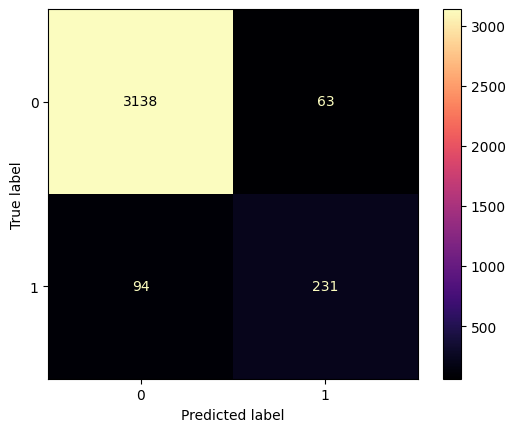

In [30]:
y_test_pred_knn = knn_clf.predict(x_test_array)

sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_knn,
    labels = knn_clf.classes_,
    cmap = 'magma'
);

plt.show()

In [31]:
print(classification_report(y_test_array,
                            y_test_pred_knn,
                            target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.79      0.71      0.75       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.86      3526
weighted avg       0.95      0.96      0.95      3526



# Creating a Support Vector Machines Model

In [32]:
# Creating an instance of the MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1))

x_train_array_svc = scaling.fit_transform(x_train_array)
x_test_array_svc = scaling.transform(x_test_array)

In [33]:
#parameters for grid search
parameters_svc = {'kernel':['linear', 'poly', 'rbf'],
                  'C':range(1, 11),
                  'gamma': ['scale', 'auto']}

In [34]:
grid_search_svc = GridSearchCV(estimator = SVC(),
                               param_grid = parameters_svc,
                               scoring = 'accuracy')

In [35]:
grid_search_svc.fit(x_train_array_svc, y_train_array)

GridSearchCV(estimator=SVC(),
             param_grid={'C': range(1, 11), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [36]:
grid_search_svc.best_estimator_

SVC(C=8, kernel='poly')

In [37]:
svc_clf = grid_search_svc.best_estimator_

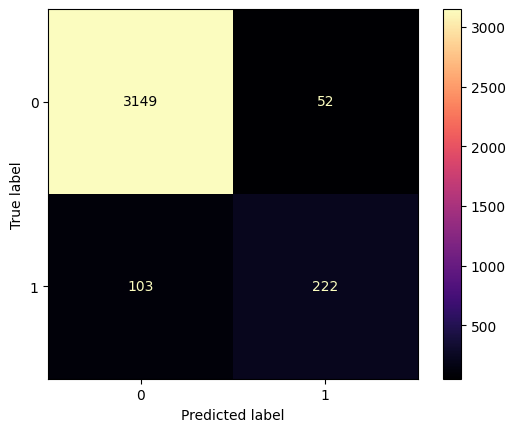

In [38]:
y_test_pred_svc = svc_clf.predict(x_test_array_svc)
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_svc,
    labels = svc_clf.classes_,
    cmap = 'magma'
);

plt.show()

In [39]:
print(classification_report(y_test_array,
                            y_test_pred_svc,
                            target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.81      0.68      0.74       325

    accuracy                           0.96      3526
   macro avg       0.89      0.83      0.86      3526
weighted avg       0.95      0.96      0.95      3526



# Creating a Decision Trees Model

In [40]:
#different values for the ccp_alpha parameter
parameters_dt = {'ccp_alpha':[0,
                              0.001,
                              0.002,
                              0.003,
                              0.004,
                              0.005]}

In [41]:
grid_search_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 365),
                              param_grid = parameters_dt,
                              scoring = 'accuracy')

In [42]:
grid_search_dt.fit(x_train_array, y_train_array)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=365),
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
             scoring='accuracy')

In [43]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.001, random_state=365)

In [44]:
dt_clf = grid_search_dt.best_estimator_

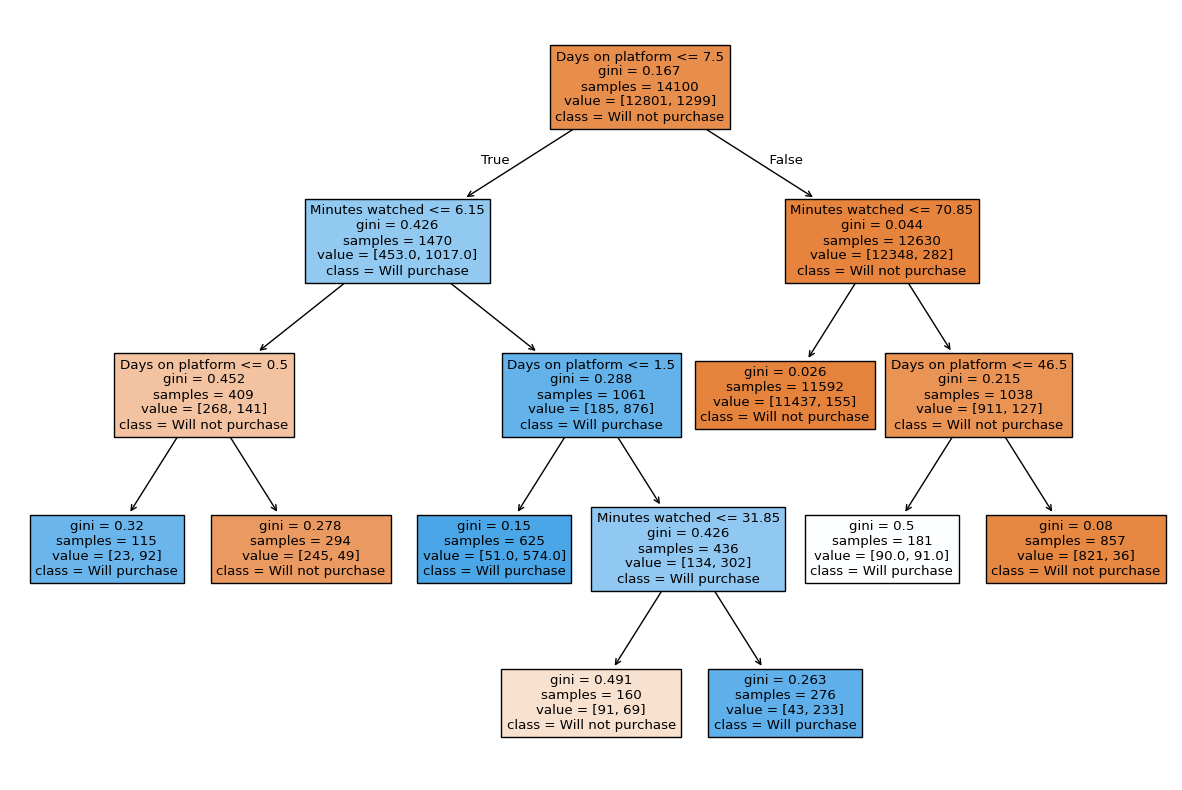

In [45]:
plt.figure(figsize=(15,10))

plot_tree(dt_clf,
          filled=True,
          feature_names = ['Days on platform',
                           'Minutes watched',
                           'Courses started',
                           'Practice exams passed',
                           'Time spent on exams',
                           'Student country encoded'],
          class_names = ['Will not purchase',
                         'Will purchase'])
plt.show()

In [46]:
y_test_pred_dt = dt_clf.predict(x_test_array)

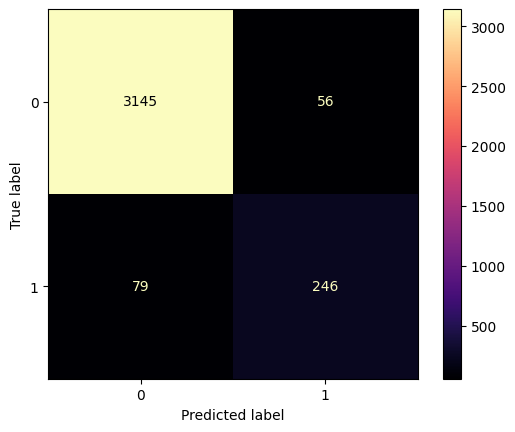

In [47]:
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_dt,
    labels = dt_clf.classes_,
    cmap = 'magma'
);

plt.show()

In [48]:
print(classification_report(y_test_array, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3201
           1       0.81      0.76      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



# Creating a Random Forests Model

In [49]:
rf_clf = RandomForestClassifier(ccp_alpha = 0.0001, random_state = 365)

In [50]:
rf_clf.fit(x_train_array, y_train_array)

RandomForestClassifier(ccp_alpha=0.0001, random_state=365)

In [51]:
y_test_pred_rf = rf_clf.predict(x_test_array)

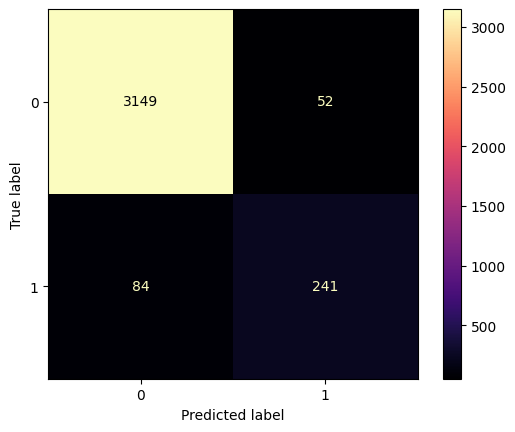

In [52]:
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_rf,
    labels = rf_clf.classes_,
    cmap = 'magma'
);

plt.show()

In [53]:
print(classification_report(y_test_array, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.82      0.74      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.86      0.88      3526
weighted avg       0.96      0.96      0.96      3526

